In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

from altaipony.ffd import FFD
from altaipony.wheatland import calculate_joint_posterior_distribution, gaussian_prior

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

for att in ['axes.labelsize', 'axes.titlesize', 'legend.fontsize',
            'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize']:
    plt.rcParams[att] = 13
    
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

paperdir="/home/ekaterina/Documents/002_writing/flares-in-clusters-ii-draft/Flares_in_Clusters_with_K2_2/"

In [2]:
ccol = dict(zip(['pleiades',"hyades","praesepe","ngc6774","ngc2682"],
                [["Pleiades","brown","x",135,25,25],
                 ["Hyades","orangered","*",690,160,100],
                 ["Praesepe","orange","d",750,3,7],
                 ["Rup 147", "green",r"$m$",2650,380,380],
                 ["M67","blue",">",3639,17,17]]))


In [3]:
df = pd.read_csv("../k2scoc/results/tables/full_table.csv")


hasflares = (df.real==1) & (df.todrop.isnull())
wassearched = (df.real==0)  & (df.todrop.isnull())
df = df[hasflares  | wassearched]

In [4]:
df["LC_time_years"] = df.dtp_tot / 2. / 24. / 365.25
df = df[(df.Teff_median<=6000) & (df.Teff_median>=2500)]
cepic = df[["LC_time_years","EPIC","C", "Teff_median", "cluster"]].drop_duplicates() 
tobs = cepic.LC_time_years.sum()

print(f"Total observing time: {tobs:.2f} years!")


bins_T = pd.cut(cepic["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=["2500-3000","3000-3250","3250-3500","3500-3750","3750-4000","4000-5000","5000-6000"])
T = cepic.groupby([bins_T, "cluster"]).LC_time_years.sum().reset_index()
assert T.LC_time_years.sum() - tobs < 1e-10
T.head()

Total observing time: 384.36 years!


,Teff_median,cluster,LC_time_years
0,2500-3000,hyades,3.201118
1,2500-3000,ngc2682,NaN
2,2500-3000,ngc6774,NaN
3,2500-3000,pleiades,9.734428
4,2500-3000,praesepe,2.125998


# Full sample FFD plots with $E_\mathrm{kp}$ and $ED$


In [5]:
resfullsample = {}

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


1166


100%|██████████| 200/200 [00:03<00:00, 52.00it/s]


Fitted power law alpha=1.988412570202109(0.02949677219868363/0.02815845004104167)
Fitted power law beta=974.2844407907617(219.51174738903046/172.68967026410064)


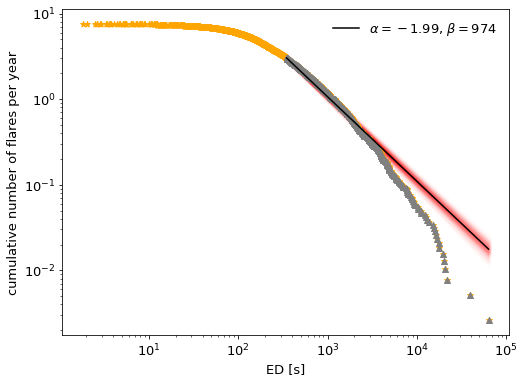

In [19]:
fig, ax =  plt.subplots(1, figsize=(8,6))
ffd = FFD(f=df[hasflares], tot_obs_time=tobs, ID="EPIC")

#---------- No correction ----------------
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)
ax.scatter(ed, freq, c="orange", marker="*")#, label="no correction")


#---------- multiple stars 
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=True)

#ax.scatter(ffd.ed, ffd.freq, marker="^", c="c", label="correcting for multiple stars in sample")

cts = pd.Series(counts).value_counts()
thresh = cts[cts==1].sort_index().index.min()
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)

ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>thresh)]
ffd.ed = ed[np.where(ed>thresh)]
ffd.freq = freq[np.where(ed>thresh)]
print(len(ffd.ed))
ffd.alpha_prior = 1.99
ffd.beta_prior = 981.75
BFA = ffd.fit_mcmc_powerlaw(steps=200)
print(f"Fitted power law alpha={ffd.alpha}({ffd.alpha_up_err}/{ffd.alpha_low_err})")
print(f"Fitted power law beta={ffd.beta}({ffd.beta_up_err}/{ffd.beta_low_err})")

ispowerlaw = ffd.is_powerlaw()
truncated = ffd.is_powerlaw_truncated()

ffd.plot_mcmc_powerlaw(ax, BFA, subset=300, linewidth=5, c="r", alpha=.005, zorder=-1)
ax.scatter(ffd.ed, ffd.freq, marker="^", c="grey", )#label="all flaring stars contribute = above detection threshold")
a, x, y = ffd.plot_powerlaw(ax, c="k", 
                            label=(fr"$\alpha=-${ffd.alpha:.2f}, "
                                   fr"$\beta=${int(np.rint(ffd.beta))}"))

plt.xscale("log")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("ED [s]")
plt.ylabel("cumulative number of flares per year")

resfullsample["alpha"] = ffd.alpha
resfullsample["alpha_up_err"] = ffd.alpha_up_err
resfullsample["alpha_low_err"] = ffd.alpha_low_err
resfullsample["beta"] = ffd.beta
resfullsample["beta_up_err"] = ffd.beta_up_err
resfullsample["beta_low_err"] = ffd.beta_low_err
resfullsample["nflares_tot"] = len(ed)
resfullsample["nflares_for_fit"] = len(ffd.ed)
resfullsample["ispowerlaw"] = ispowerlaw
resfullsample["istruncated"] = truncated

plt.savefig(f"plots/{tstamp}_full_sample_ffd_ED_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/full_sample_ffd_ED_wheatland.png", dpi=300)

In [20]:
ispowerlaw

False

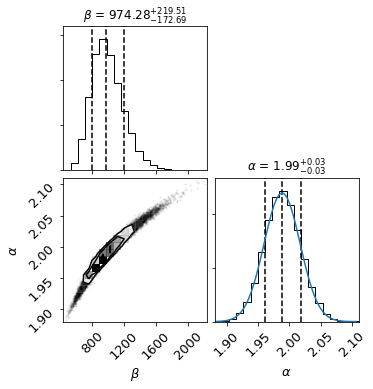

In [21]:
BFA.show_corner_plot(show_truths=False)


x = np.linspace(resfullsample["alpha"] - resfullsample["alpha_low_err"]*4,
                resfullsample["alpha"] + resfullsample["alpha_up_err"]*4,100)
plt.plot(x, 345*gaussian_prior(x, resfullsample["alpha"], 
                            (resfullsample["alpha_up_err"] + resfullsample["alpha_low_err"]) / 2.))

In [22]:
def loglikelihood_gauss_wheatland_ed(theta, *args):
    '''Log likelihood to pass to BayesianFlaringAnalysis
    for fitting the powerlaw following Wheatland 2004.
    Using a gaussian prior for alpha.
    '''
    def prior(x):
        return gaussian_prior(x, resfullsample["alpha"], 
                           (resfullsample["alpha_up_err"] + resfullsample["alpha_low_err"]) / 2.)
    return calculate_joint_posterior_distribution(theta, *args, prior)

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
100%|██████████| 200/200 [00:03<00:00, 50.33it/s]


Fitted power law alpha=1.87055962157143(0.023592742523670163/0.023195396470105933)
Fitted power law beta=7.1647275684019315e+28(3.617631789281579e+29/5.937511676634336e+28)


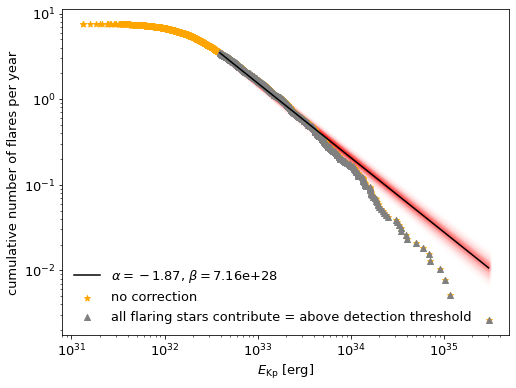

In [23]:
fig, ax =  plt.subplots(1, figsize=(8,6))
df2 = copy.deepcopy(df)
df2["ed_rec"] = df.ed_rec * df.Lum_Kepler
ffd = FFD(f=df2[hasflares & ~(df.ed_rec.isnull())], tot_obs_time=tobs, ID="EPIC")

#---------- No correction ----------------
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)
ax.scatter(ed, freq, c="orange", marker="*", label="no correction")


#---------- multiple stars 
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=True)

#ax.scatter(ffd.ed, ffd.freq, marker="^", c="c", label="correcting for multiple stars in sample")

cts = pd.Series(counts).value_counts()
thresh = cts[cts==1].sort_index().index.min()

ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)

ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>thresh)]
ffd.ed = ed[np.where(ed>thresh)]
ffd.freq = freq[np.where(ed>thresh)]

ffd.alpha_prior = 1.85
ffd.beta_prior = 1.75e28
BFA = ffd.fit_mcmc_powerlaw(steps=200.)
print(f"Fitted power law alpha={ffd.alpha}({ffd.alpha_up_err}/{ffd.alpha_low_err})")
print(f"Fitted power law beta={ffd.beta}({ffd.beta_up_err}/{ffd.beta_low_err})")
ispowerlaw = ffd.is_powerlaw()
truncated = ffd.is_powerlaw_truncated()

ffd.plot_mcmc_powerlaw(ax, BFA, subset=300,linewidth=5, c="r", alpha=.005, zorder=-1)
ax.scatter(ffd.ed, ffd.freq, marker="^", c="grey", label="all flaring stars contribute = above detection threshold")
a, x, y = ffd.plot_powerlaw(ax, c="k", label=fr"$\alpha=-${ffd.alpha:.2f}, $\beta=${ffd.beta:.2e}")


resfullsample["alpha_en"] = ffd.alpha
resfullsample["alpha_up_err_en"] = ffd.alpha_up_err
resfullsample["alpha_low_err_en"] = ffd.alpha_low_err
resfullsample["beta_en"] = ffd.beta
resfullsample["beta_up_err_en"] = ffd.beta_up_err
resfullsample["beta_low_err_en"] = ffd.beta_low_err
resfullsample["nflares_tot_en"] = len(ed)
resfullsample["nflares_for_fit_en"] = len(ffd.ed)
resfullsample["ispowerlaw_en"] = ispowerlaw
resfullsample["istruncated_en"] = truncated

plt.xscale("log")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel(r"$E_\mathrm{Kp}$ [erg]")
plt.ylabel("cumulative number of flares per year")

plt.savefig(f"plots/{tstamp}_full_sample_ffd_energy_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/full_sample_ffd_energy_wheatland.png", dpi=300)

In [24]:
ispowerlaw

False

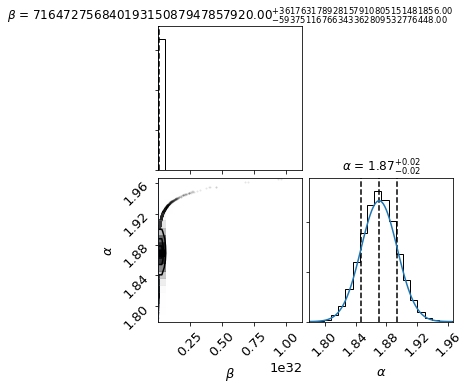

In [25]:
BFA.show_corner_plot(show_truths=False, )
x = np.linspace(resfullsample["alpha_en"] - resfullsample["alpha_low_err_en"]*4,
                resfullsample["alpha_en"] + resfullsample["alpha_up_err_en"]*4,100)
plt.plot(x, 285*gaussian_prior(x, resfullsample["alpha_en"], 
                            (resfullsample["alpha_up_err_en"] + resfullsample["alpha_low_err_en"]) / 2.))

In [26]:
def loglikelihood_gauss_wheatland_energy(theta, *args):
    '''Log likelihood to pass to BayesianFlaringAnalysis
    for fitting the powerlaw following Wheatland 2004.
    Using a gaussian prior for alpha.
    '''
    def prior(x):
        return gaussian_prior(x, resfullsample["alpha_en"], 
                           (resfullsample["alpha_up_err_en"] + resfullsample["alpha_low_err_en"]) / 2.)
    return calculate_joint_posterior_distribution(theta, *args, prior)

In [27]:
_t = pd.Series(resfullsample)
resfulltab =  pd.DataFrame({"space": [r"$ED$", r"$E_\mathrm{Kp}$"],
              r"$\alpha$":[f"${_t.alpha:.2f}\left(OK1{_t.alpha_up_err:.2f}K2UK1{_t.alpha_up_err:.2f}K2\right)$",
                           f"${_t.alpha_en:.2f}\left(OK1{_t.alpha_up_err_en:.2f}K2UK1{_t.alpha_up_err_en:.2f}K2\right)$",],
              r"$\beta$ [yr$^{-1}$]":[f"${int(np.rint(_t.beta))}\left(OK1{int(np.rint(_t.beta_up_err))}K2UK1{int(np.rint(_t.beta_low_err))}K2\right)$",
                          f"${_t.beta_en/10**28:.2f}\left(OK1{_t.beta_up_err_en/10**28:.2f}K2UK1{_t.beta_low_err_en/10**28:.2f}K2\right)" + r"\cdot 10^{28}$"],
              r"$n_\mathrm{tot}$":[_t.nflares_tot,_t.nflares_tot_en,],
              r"$n_\mathrm{fit}$":[_t.nflares_for_fit,_t.nflares_for_fit_en,],
             # r"$tr$":[_t.istruncated,_t.istruncated_en,],
             # r"$pl$":[_t.ispowerlaw,_t.ispowerlaw_en,]
             })

resfulltab[r"$\alpha$"] = (resfulltab[r"$\alpha$"].str
                           .replace("O",r"^").str
                           .replace("U",r"_").str
                           .replace("K1",r"{").str
                           .replace("K2",r"}"))

resfulltab[r"$\beta$ [yr$^{-1}$]"] = (resfulltab[r"$\beta$ [yr$^{-1}$]"].str
                           .replace("O",r"^").str
                           .replace("U",r"_").str
                           .replace("K1",r"{").str
                           .replace("K2",r"}"))
names = resfulltab['space'].values
resfulltab = resfulltab.T

resfulltab = resfulltab.rename(index=str, columns=dict(zip(resfulltab.columns.values, names)))
resfulltab = resfulltab.drop("space")
nc = 'c' * (resfulltab.shape[1])
stri = resfulltab.to_latex(index=True,escape=False, column_format=f"l{nc}r")
stri = stri.replace("\\toprule","\hline")
stri = stri.replace("\\midrule","\hline")


stri = stri.replace("\\bottomrule","\hline\n" )
stri = stri.replace("{}"," " )

with open(f"{paperdir}tables/powerlaw_fullsample_wheatland.tex", "w") as f:
    f.write(stri)

print(stri)

\begin{tabular}{lccr}
\hline
  &                               $ED$ &                                  $E_\mathrm{Kp}$ \\
\hline
$\alpha$            &  $1.99\left(^{0.03}_{0.03}\right)$ &                $1.87\left(^{0.02}_{0.02}\right)$ \\
$\beta$ [yr$^{-1}$] &     $974\left(^{220}_{173}\right)$ &  $7.16\left(^{36.18}_{5.94}\right)\cdot 10^{28}$ \\
$n_\mathrm{tot}$    &                               2913 &                                             2913 \\
$n_\mathrm{fit}$    &                               1166 &                                             1336 \\
\hline

\end{tabular}



In [28]:
with open(f"{paperdir}values/MCMC_alpha_ed.txt", "w") as f:
    f.write(str(np.round(resfullsample["alpha"],2)))
with open(f"{paperdir}values/MCMC_alpha_energy.txt", "w") as f:
    f.write(str(np.round(resfullsample["alpha_en"],2)))

## Teff bins


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|██████████| 200/200 [00:02<00:00, 72.64it/s]


Fitted power law alpha=1.9903707867607148(0.028390215868042024/0.0283472328390737)
Fitted power law beta=1193.6248646694144(500.96097321860884/370.01794863767316)


100%|██████████| 200/200 [00:02<00:00, 74.13it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=1.9891884570917509(0.028613620898402692/0.028649004982576054)
Fitted power law beta=3757.079565023385(1688.9021213428878/1222.1778675789187)


100%|██████████| 200/200 [00:03<00:00, 65.93it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.0009705685455956(0.026112418967302098/0.02585339029882916)
Fitted power law beta=2581.2139230058847(569.7480640823624/466.4993713943845)


100%|██████████| 200/200 [00:02<00:00, 71.05it/s]


Fitted power law alpha=1.9832683006128173(0.02776455976641201/0.027605491053935394)
Fitted power law beta=1462.2506014933083(353.0457115939039/285.1776317498386)


100%|██████████| 200/200 [00:02<00:00, 70.40it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=1.9943981546604097(0.027204558737591977/0.027469881382439887)
Fitted power law beta=1475.8615980174518(385.4184477582785/306.84485588056486)


100%|██████████| 200/200 [00:03<00:00, 63.83it/s]


Fitted power law alpha=1.995773821896885(0.025446306306501132/0.025402623723598916)
Fitted power law beta=2116.8791358335666(396.4139789884657/334.68851459140205)


100%|██████████| 200/200 [00:02<00:00, 71.36it/s]


Fitted power law alpha=1.9926023279550615(0.027467896540300796/0.027955459843862718)
Fitted power law beta=1218.5482454536468(262.36284145337413/218.65412490189476)


100%|██████████| 200/200 [00:02<00:00, 67.79it/s]


Fitted power law alpha=1.9911113223110655(0.02654753368784979/0.026298761747148403)
Fitted power law beta=1137.442235384432(233.2527862670379/189.98337895871464)


100%|██████████| 200/200 [00:02<00:00, 75.87it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=1.989740604519067(0.028209349412784857/0.028575663791629458)
Fitted power law beta=186.5797611232028(106.76468919431358/74.6406834177108)


100%|██████████| 200/200 [00:02<00:00, 70.31it/s]


Fitted power law alpha=1.9913575250955189(0.0278746385545241/0.0277986109961208)
Fitted power law beta=940.4736231009489(198.4092314657115/166.82081155847777)


100%|██████████| 200/200 [00:02<00:00, 73.26it/s]


Fitted power law alpha=1.991190171033805(0.028374469082816045/0.028830368047515043)
Fitted power law beta=790.9656998691228(213.0029537174372/173.679707861422)


100%|██████████| 200/200 [00:02<00:00, 72.75it/s]


Fitted power law alpha=1.9896870322865994(0.02849640619613525/0.028463407771515792)
Fitted power law beta=148.9957983064237(36.87898179150781/30.160146248601507)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|██████████| 200/200 [00:02<00:00, 73.89it/s]


Fitted power law alpha=1.9980736457863615(0.028060318973962328/0.028398717200669887)
Fitted power law beta=762.7917973814117(192.8742277443639/155.5210073247016)


100%|██████████| 200/200 [00:02<00:00, 73.69it/s]


Fitted power law alpha=1.9861157849576376(0.028725498324613463/0.028718311795505214)
Fitted power law beta=34.53412206974516(13.44415549190041/10.389293168185251)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|██████████| 200/200 [00:02<00:00, 71.79it/s]


Fitted power law alpha=1.9898142563975725(0.02758542049924806/0.027836322119844104)
Fitted power law beta=516.4414646124344(119.58992526652469/98.27135662557544)


100%|██████████| 200/200 [00:02<00:00, 74.70it/s]


Fitted power law alpha=1.9888180105836368(0.02838500853325243/0.028441859516090462)
Fitted power law beta=13.54579038262229(6.209517811146274/4.662133331873715)


100%|██████████| 200/200 [00:02<00:00, 74.07it/s]


Fitted power law alpha=1.9822759636803557(0.02850682186907716/0.028393276394434785)
Fitted power law beta=15.00953279900095(4.27213512988833/3.5350588279635424)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|██████████| 200/200 [00:02<00:00, 73.60it/s]


Fitted power law alpha=1.9851105212514772(0.02870349755382451/0.0286285931908834)
Fitted power law beta=44.487179822701115(12.7452300192247/10.364327639209023)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [00:02<00:00, 72.52it/s]


Fitted power law alpha=1.9916067895209904(0.028606882022019775/0.028662733829915243)
Fitted power law beta=21.080630365203355(6.363095667007791/5.144672445424041)


100%|██████████| 200/200 [00:02<00:00, 75.85it/s]


Fitted power law alpha=1.989095139705186(0.028389604216600972/0.02856989206294447)
Fitted power law beta=37.77359191288356(21.504782428126937/15.267018376942264)


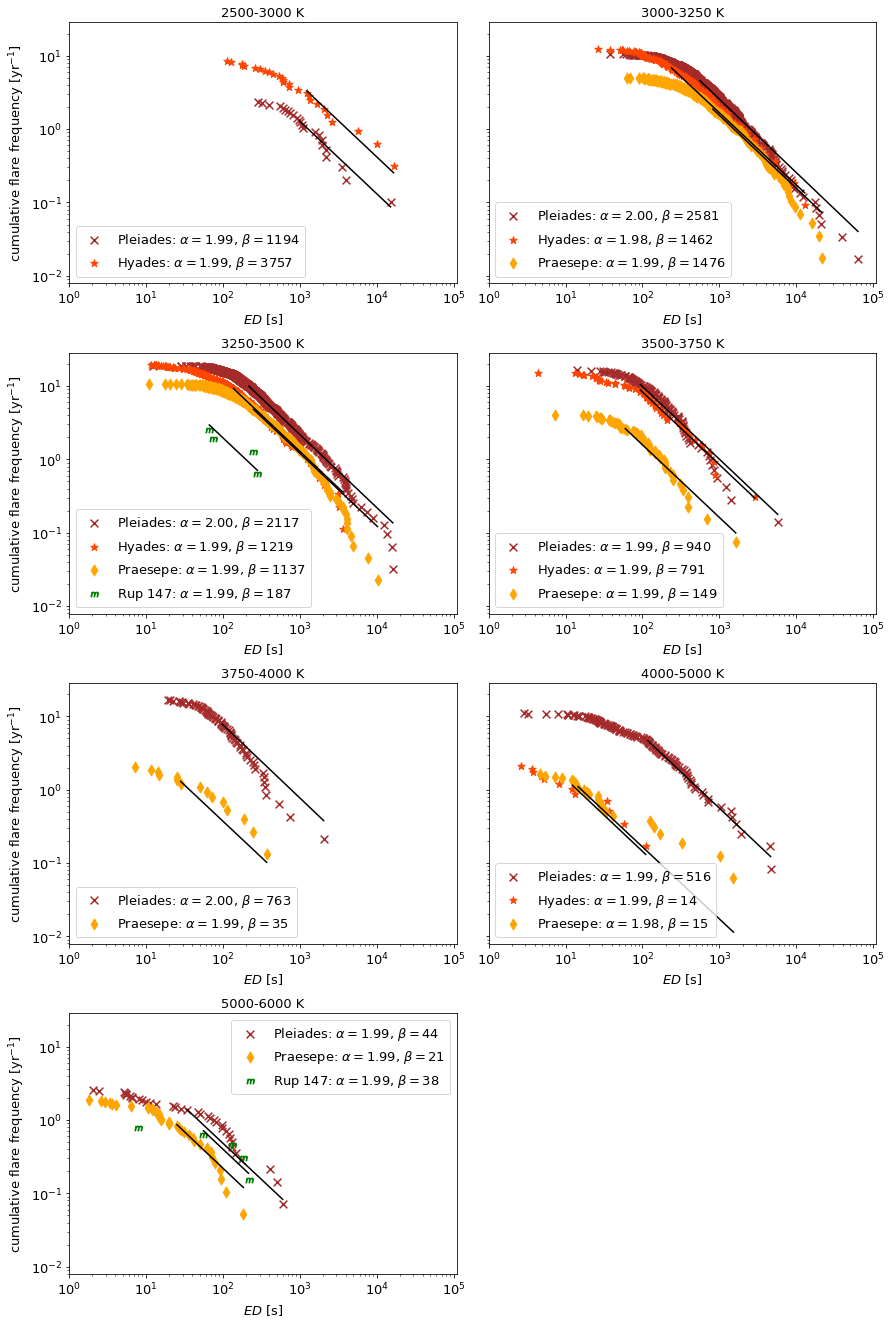

In [29]:
labels=["2500-3000","3000-3250","3250-3500","3500-3750","3750-4000","4000-5000","5000-6000"]
bins_T = pd.cut(df["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=labels)

resed = {}

fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(12.5,18.5), sharey=True, squeeze=True)
k = 0
axes = [l for x in axes for l in x]
for i, g in df.groupby(bins_T):
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["pleiades","hyades","praesepe","ngc6774", "ngc2682"],
                      ordered=True)
    resed[i]={}
    for j, h in g.groupby("cluster"):
      
       # print(i,j)
       # print(h.shape)
        tobs = T[(T.Teff_median == i) & (T.cluster == j)].LC_time_years.values[0]
        h = h[(h.real == 1)]
        if h.shape[0] == 0:
            continue
        else:
            ffd = FFD(f=h, tot_obs_time=tobs, ID="EPIC")

            #---------- get thershold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=True)
            
            cts = pd.Series(counts).value_counts()
            thresh = cts[cts==1].sort_index().index.min()
            
            # ----------- use threshold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>=thresh)]
            ffd.ed = ed[np.where(ed>=thresh)]
            ffd.freq = freq[np.where(ed>=thresh)]

            ffd.alpha_prior = resfullsample["alpha"]
            ffd.beta_prior = resfullsample["beta"]
            if len(ffd.ed) < 3:
                continue
            BFA = ffd.fit_mcmc_powerlaw(steps=200,loglikelihood=loglikelihood_gauss_wheatland_ed)
            print(f"Fitted power law alpha={ffd.alpha}({ffd.alpha_up_err}/{ffd.alpha_low_err})")
            print(f"Fitted power law beta={ffd.beta}({ffd.beta_up_err}/{ffd.beta_low_err})")
            if j == "ngc2682":
                E, y = ffd.ed[0], ffd.freq[0]
                ffd.beta = y * np.power(E, ffd.alpha-1)
                a, x, y = ffd.plot_powerlaw(axes[k], c="k",)
                
            else:
                a, x, y = ffd.plot_powerlaw(axes[k], c="k",)
            
            resed[i][ccol[j][0]]={"alpha":ffd.alpha,
                                  "alpha_up_err":ffd.alpha_up_err,
                                  "alpha_low_err":ffd.alpha_low_err,
                                  "beta":ffd.beta,
                                  "beta_up_err":ffd.beta_up_err,
                                  "beta_low_err":ffd.beta_low_err,
                                  "nflares":len(ed),
                                  "age":ccol[j][3],
                                  "age_uperr":ccol[j][4],
                                  "age_lowerr":ccol[j][5],
                                  "ispowerlaw":ffd.is_powerlaw(),
                                  "istruncated": ffd.is_powerlaw_truncated()
                                  }
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)

            axes[k].scatter(ed, freq, c=ccol[j][1], marker=ccol[j][2], s=60,
                            label=fr"{ccol[j][0]}: $\alpha=${ffd.alpha:.2f}, $\beta=${ffd.beta:.0f}")

            axes[k].set_xscale('log')
            axes[k].set_yscale('log')
            axes[k].set_title(f"{i} K")
            axes[k].set_xlim(1, 1.1e5)
            axes[k].set_xlabel(r"$ED$ [s]")
            axes[k].legend()

            
            
    k += 1
axes[-1].axis('off')
for i in [0,2,4,6]:
    axes[i].set_ylabel(r"cumulative flare frequency [yr$^{-1}$]")

plt.tight_layout()
plt.savefig(f"plots/{tstamp}_SpT_wise_sample_ffd_ED_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/SpT_wise_sample_ffd_ED_wheatland.png", dpi=300)

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|██████████| 200/200 [00:02<00:00, 74.36it/s]


Fitted power law alpha=1.87(0.02/0.02)
Fitted power law beta=1.31e+28(6.52e+28/1.09e+28)


100%|██████████| 200/200 [00:02<00:00, 71.52it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=1.87(0.02/0.02)
Fitted power law beta=3.89e+28(1.86e+29/3.23e+28)


100%|██████████| 200/200 [00:03<00:00, 63.83it/s]


Fitted power law alpha=1.90(0.02/0.02)
Fitted power law beta=6.24e+29(2.45e+30/4.96e+29)


100%|██████████| 200/200 [00:02<00:00, 68.94it/s]


Fitted power law alpha=1.87(0.02/0.02)
Fitted power law beta=6.23e+28(2.77e+29/5.11e+28)


100%|██████████| 200/200 [00:02<00:00, 68.96it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=1.89(0.02/0.02)
Fitted power law beta=2.04e+29(9.36e+29/1.66e+29)


100%|██████████| 200/200 [00:03<00:00, 62.02it/s]


Fitted power law alpha=1.90(0.02/0.02)
Fitted power law beta=2.00e+30(7.92e+30/1.60e+30)


100%|██████████| 200/200 [00:02<00:00, 70.65it/s]


Fitted power law alpha=1.88(0.02/0.02)
Fitted power law beta=1.77e+29(8.06e+29/1.45e+29)


100%|██████████| 200/200 [00:03<00:00, 61.76it/s]


Fitted power law alpha=1.89(0.02/0.02)
Fitted power law beta=6.34e+29(2.63e+30/5.10e+29)


100%|██████████| 200/200 [00:02<00:00, 74.54it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=1.87(0.02/0.02)
Fitted power law beta=1.81e+28(8.98e+28/1.52e+28)


100%|██████████| 200/200 [00:02<00:00, 68.75it/s]


Fitted power law alpha=1.88(0.02/0.02)
Fitted power law beta=3.67e+29(1.69e+30/3.02e+29)


100%|██████████| 200/200 [00:02<00:00, 72.49it/s]


Fitted power law alpha=1.87(0.02/0.02)
Fitted power law beta=3.01e+29(1.49e+30/2.50e+29)


100%|██████████| 200/200 [00:02<00:00, 66.73it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=1.87(0.02/0.02)
Fitted power law beta=5.19e+28(2.45e+29/4.30e+28)


100%|██████████| 200/200 [00:02<00:00, 70.19it/s]


Fitted power law alpha=1.88(0.02/0.02)
Fitted power law beta=8.66e+29(4.30e+30/7.19e+29)


100%|██████████| 200/200 [00:02<00:00, 69.23it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=1.87(0.02/0.02)
Fitted power law beta=2.96e+28(1.48e+29/2.47e+28)


100%|██████████| 200/200 [00:02<00:00, 68.10it/s]


Fitted power law alpha=1.87(0.02/0.02)
Fitted power law beta=7.01e+29(3.44e+30/5.84e+29)


100%|██████████| 200/200 [00:02<00:00, 67.22it/s]


Fitted power law alpha=1.87(0.02/0.02)
Fitted power law beta=2.40e+28(1.23e+29/2.01e+28)


100%|██████████| 200/200 [00:02<00:00, 71.57it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=1.87(0.02/0.02)
Fitted power law beta=3.60e+28(1.81e+29/3.01e+28)


100%|██████████| 200/200 [00:02<00:00, 68.77it/s]


Fitted power law alpha=1.87(0.02/0.02)
Fitted power law beta=2.81e+29(1.44e+30/2.37e+29)


100%|██████████| 200/200 [00:03<00:00, 65.21it/s]


Fitted power law alpha=1.87(0.02/0.02)
Fitted power law beta=1.68e+29(8.57e+29/1.41e+29)


100%|██████████| 200/200 [00:02<00:00, 71.73it/s]


Fitted power law alpha=1.87(0.02/0.02)
Fitted power law beta=1.65e+29(9.18e+29/1.40e+29)


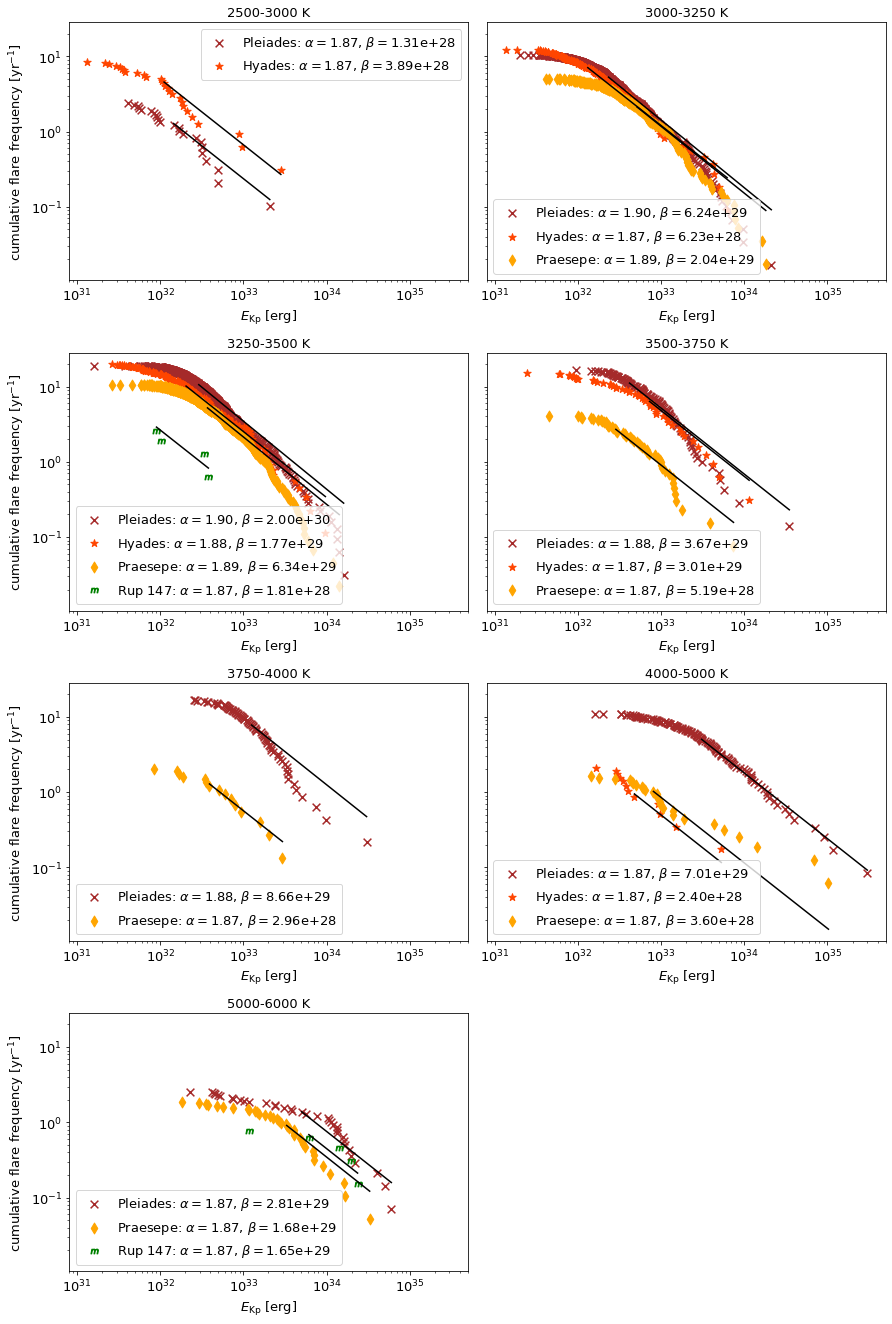

In [30]:
resen = {}
df2 = copy.deepcopy(df)
df2["ed_rec"] = df.ed_rec * df.Lum_Kepler
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12.5,18.5),
                         sharey=True, squeeze=True)
k = 0
axes = [l for x in axes for l in x]
for i, g in df2.groupby(bins_T):
    resen[i]={}
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["pleiades","hyades",
                                  "praesepe","ngc6774",
                                  "ngc2682"],
                      ordered=True)
    for j, h in g.groupby("cluster"):

        tobs = T[(T.Teff_median == i) &
                 (T.cluster == j)].LC_time_years.values[0]
        h = h[(h.real == 1)]
        if h.shape[0] == 0:
            continue
        else:
            ffd = FFD(f=h, tot_obs_time=tobs, ID="EPIC")

            #---------- get thershold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=True)
            
            cts = pd.Series(counts).value_counts()
            thresh = cts[cts==1].sort_index().index.min()
            
            # ----------- use threshold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>=thresh)]
            ffd.ed = ed[np.where(ed>=thresh)]
            ffd.freq = freq[np.where(ed>=thresh)]

            ffd.alpha_prior = resfullsample["alpha_en"]
            ffd.beta_prior = resfullsample["beta_en"]
            
            if len(ffd.ed) < 3:
                continue
            BFA = ffd.fit_mcmc_powerlaw(steps=200,loglikelihood=loglikelihood_gauss_wheatland_energy)
            print(f"Fitted power law alpha={ffd.alpha:.2f}({ffd.alpha_up_err:.2f}/{ffd.alpha_low_err:.2f})")
            print(f"Fitted power law beta={ffd.beta:.2e}({ffd.beta_up_err:.2e}/{ffd.beta_low_err:.2e})")
            
            if j == "ngc2682":
                E, y = ffd.ed[0], ffd.freq[0]
                ffd.beta = y * np.power(E, ffd.alpha-1)
                a, x, y = ffd.plot_powerlaw(axes[k], c="k",)
                
            else:
                a, x, y = ffd.plot_powerlaw(axes[k], c="k",)
            
            
            resen[i][ccol[j][0]]= {"alpha_en":ffd.alpha,
                                  "alpha_up_err_en":ffd.alpha_up_err,
                                  "alpha_low_err_en":ffd.alpha_low_err,
                                  "beta_en":ffd.beta,
                                  "beta_up_err_en":ffd.beta_up_err,
                                  "beta_low_err_en":ffd.beta_low_err,
                                  "nflares_en":len(ed),
                                  "age":ccol[j][3],
                                  "age_uperr":ccol[j][4],
                                  "age_lowerr":ccol[j][5],
                                  "ispowerlaw_en":ffd.is_powerlaw(),
                                  "istruncated_en": ffd.is_powerlaw_truncated()
                                  }
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            axes[k].scatter(ed, freq, c=ccol[j][1], marker=ccol[j][2], s=60,
                           label=fr"{ccol[j][0]}: $\alpha=${ffd.alpha:.2f}, $\beta=${ffd.beta:.2e}")

            axes[k].set_xscale('log')
            axes[k].set_yscale('log')
            axes[k].set_title(f"{i} K")
            axes[k].set_xlim(8e30, 5e35)
            axes[k].set_xlabel(r"$E_\mathrm{Kp}$ [erg]")
            axes[k].legend()
            
            
    k += 1
axes[-1].axis('off')
for i in [0,2,4,6]:
    axes[i].set_ylabel(r"cumulative flare frequency [yr$^{-1}$]")

plt.tight_layout()
plt.savefig(f"plots/{tstamp}_SpT_wise_sample_ffd_energy_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/SpT_wise_sample_ffd_energy_wheatland.png", dpi=300)

In [31]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in resed.items() for innerKey, values in innerDict.items()}

betaed_ = pd.DataFrame(reform).T
betaed = betaed_.reset_index().rename(index=str, columns={"level_0":"Teff",
                                                                          "level_1":"cluster"}) 

reform = {(outerKey, innerKey): values for outerKey, innerDict in resen.items() for innerKey, values in innerDict.items()}

betaen_ = pd.DataFrame(reform).T
betaen = betaen_.reset_index().rename(index=str, columns={"level_0":"Teff",
                                                                       "level_1":"cluster"})
beta = betaed.merge(betaen)
beta["Tmin"] = beta.Teff.apply(lambda x: int(x.split("-")[0]))
beta["Tmax"] = beta.Teff.apply(lambda x: int(x.split("-")[1]))
beta["Tmid"] = ((beta.Tmax + beta.Tmin) / 2).astype(int)
beta["Tmid_err"] = ((beta.Tmax - beta.Tmin) / 2).astype(int)
beta.sort_values(by="nflares")

,Teff,cluster,alpha,alpha_up_err,alpha_low_err,beta,beta_up_err,beta_low_err,nflares,age,...,beta_en,beta_up_err_en,beta_low_err_en,nflares_en,ispowerlaw_en,istruncated_en,Tmin,Tmax,Tmid,Tmid_err
8,3250-3500,Rup 147,1.98974,0.0282093,0.0285757,186.58,106.765,74.6407,4,2650,...,1.80594e+28,8.97813e+28,1.51746e+28,4,True,False,3250,3500,3375,125
19,5000-6000,Rup 147,1.9891,0.0283896,0.0285699,37.7736,21.5048,15.267,5,2650,...,1.64659e+29,9.18198e+29,1.39609e+29,5,True,False,5000,6000,5500,500
15,4000-5000,Hyades,1.98882,0.028385,0.0284419,13.5458,6.20952,4.66213,12,690,...,2.39896e+28,1.23353e+29,2.00744e+28,12,True,False,4000,5000,4500,500
13,3750-4000,Praesepe,1.98612,0.0287255,0.0287183,34.5341,13.4442,10.3893,15,750,...,2.95569e+28,1.47667e+29,2.47422e+28,15,True,False,3750,4000,3875,125
0,2500-3000,Pleiades,1.99037,0.0283902,0.0283472,1193.62,500.961,370.018,23,135,...,1.31297e+28,6.51699e+28,1.08688e+28,23,True,False,2500,3000,2750,250
16,4000-5000,Praesepe,1.98228,0.0285068,0.0283933,15.0095,4.27214,3.53506,26,750,...,3.60262e+28,1.80956e+29,3.00533e+28,26,True,False,4000,5000,4500,500
1,2500-3000,Hyades,1.98919,0.0286136,0.028649,3757.08,1688.9,1222.18,27,690,...,3.88604e+28,1.85606e+29,3.23335e+28,27,True,False,2500,3000,2750,250
18,5000-6000,Praesepe,1.99161,0.0286069,0.0286627,21.0806,6.3631,5.14467,36,750,...,1.67584e+29,8.57185e+29,1.40921e+29,36,True,False,5000,6000,5500,500
17,5000-6000,Pleiades,1.98511,0.0287035,0.0286286,44.4872,12.7452,10.3643,36,135,...,2.80726e+29,1.43534e+30,2.36684e+29,36,True,False,5000,6000,5500,500
10,3500-3750,Hyades,1.99119,0.0283745,0.0288304,790.966,213.003,173.68,49,690,...,3.00908e+29,1.49033e+30,2.50295e+29,49,True,False,3500,3750,3625,125


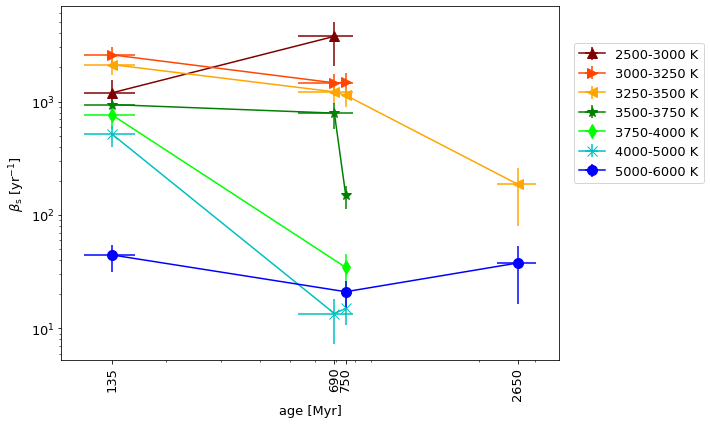

In [33]:
fig, ax = plt.subplots(figsize=(10,6))
Tcols = {"2750":["^","maroon"],
         "3125":[">","orangered"],
         "3375":["<","orange"],
         "3625":["*","green"],
         "3875":["d","lime"],
         "4500":["x","c"],
         "5500":["o","blue"],}
for label, g in beta.groupby("Tmid"):
 
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["Pleiades","Hyades","Praesepe","Rup 147", "M67"],
                      ordered=True)
    g = g.sort_values(by="cluster")
    ax.errorbar(x=g.age, xerr=g[["age_uperr","age_lowerr"]].values.T,
                 y=g.beta, yerr=g[["beta_up_err","beta_low_err"]].values.T,
                 label=f"{g.Tmin.iloc[0]}-{g.Tmax.iloc[0]} K",c=Tcols[str(label)][1],
                  marker=Tcols[str(label)][0],markersize=10)
#     g.plot(x="age", xerr="age_uperr",y="beta",yerr="beta_err",
#            label=f"{g.Tmin.iloc[0]}-{g.Tmax.iloc[0]} K", ax=ax, kind="line",c=Tcols[str(label)][1],
#           marker=Tcols[str(label)][0],markersize=10)#s=120,)#
    

ax.set_xlabel("age [Myr]")
ax.set_ylabel(r"$\beta_\mathrm{s}$ [yr$^{-1}$]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks(beta.age.astype(float).unique())
ax.set_xticklabels(labels=beta.age.unique(), rotation=90)
ax.legend(loc=(1.03,.5))
plt.tight_layout()
plt.savefig(f"plots/{tstamp}_beta_T_age_ED_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/beta_T_age_ED_wheatland.png", dpi=300)

In [34]:
beta_s = betaen_.merge(betaed_, left_index=True,right_index=True)
for b in ["beta","beta_up_err","beta_low_err",
          "beta_en","beta_up_err_en", "beta_low_err_en"]:
    beta_s.loc[:,b] = beta_s[b].astype(float)


for out, beta, beta_up_err, beta_low_err in [(r"$\beta_\mathrm{s}$","beta","beta_up_err", "beta_low_err"),
                                             (r"$\beta_\mathrm{erg}$","beta_en","beta_up_err_en", "beta_low_err_en"),
                                           
                            ]:
    if out == r"$\beta_\mathrm{erg}$":
        beta_s["perr"] = (np.rint(np.log10(beta_s[beta]/beta_s[beta_up_err]))+2).astype(int)
        beta_s["b"] = (np.rint(np.log10(beta_s[beta]))).astype(int)
        beta_s["berr"] = (np.rint(np.log10(beta_s[beta_up_err]))).astype(int)
        beta_s["B"] = beta_s.apply(lambda x: np.round(x[beta]/10**x.b, x.perr).astype(str), axis=1)
        beta_s["Berr_up"] = beta_s.apply(lambda x: np.round(x[beta_up_err]/10**x.b, x.perr), axis=1)     
        beta_s["Berr_low"] = beta_s.apply(lambda x: np.round(x[beta_low_err]/10**x.b, x.perr), axis=1) 
    
        beta_s[out] = beta_s.apply(lambda x: f"${x.B}\left(OK1{x.Berr_up}K2UK1{x.Berr_low}K2\right)\cdot 10OK1{x.b}K2$", axis=1)
    else: 
        beta_s[out] = beta_s.apply(lambda x: f"${int(x[beta])}\left(OK1{int(x[beta_up_err])}K2UK1{int(x[beta_low_err])}K2\right)$", axis=1)
    beta_s[out] = (beta_s[out].str
                           .replace("O",r"^").str
                           .replace("U",r"_").str
                           .replace("K1",r"{").str
                           .replace("K2",r"}"))

    
for out, beta, beta_up_err, beta_low_err in [(r"$\alpha_\mathrm{erg}$","alpha_en","alpha_up_err_en", "alpha_low_err_en"),
                                             (r"$\alpha_\mathrm{s}$","alpha","alpha_up_err", "alpha_low_err"),
                            ]:    
    beta_s[out] = beta_s.apply(lambda x: f"${x[beta]:.2f}\left(OK1{x[beta_up_err]:.2f}K2UK1{x[beta_low_err]:.2f}K2\right)$", axis=1)
    beta_s[out] = (beta_s[out].str
                           .replace("O",r"^").str
                           .replace("U",r"_").str
                           .replace("K1",r"{").str
                           .replace("K2",r"}"))    
    
rename = {"nflares":r"$n_\mathrm{s}$",
         "nflares_en":r"$n_\mathrm{erg}$",
        #  "istruncated":r"$tr_\mathrm{s}$",
        # "istruncated_en":r"$tr_\mathrm{erg}$",
        # "ispowerlaw":r"$pl_\mathrm{s}$",
        # "ispowerlaw_en":r"$pl_\mathrm{erg}$",
         }
beta_s = beta_s[[r"$\alpha_\mathrm{s}$",r"$\beta_\mathrm{s}$","nflares",#"istruncated","ispowerlaw",,"istruncated_en","ispowerlaw_en"
                 r"$\alpha_\mathrm{erg}$",r"$\beta_\mathrm{erg}$","nflares_en",]].rename(index=str, columns=rename)
beta_s = beta_s.sort_index()
nc = 'c' * (beta_s.shape[1])
stri = beta_s.to_latex(index=True,escape=False, column_format=f"l{nc}r")
stri = stri.replace("\\toprule","\hline")
stri = stri.replace("\\midrule","\hline")


stri = stri.replace("\\bottomrule","\hline\n" )
with open(f"{paperdir}tables/powerlaw_SpT_wheatland.tex", "w") as f:
    f.write(stri)

# Notes on very old clusters

## Rup 147

- 219426848 spectroscopic binary with double line (Curtis 2013)
- **219591752** unremarkable Gaia target [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=19+14+11.962+%09-16+21+38.93+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=) the cool star! 3315 K
- 219341906 - nothing special from Curtis 2013
- **219601739** - nothing special from Curtis 2013, CWW79
- **219610232** - unremarkable Gaia target [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=19+13+31.091+%09-16+18+40.14+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=), Cantat-Gaudin+ 2018: 100% member

In [ ]:

df[(df.cluster=="ngc6774") & (df.Teff_median > 3000.)].dropna(subset=["real"])[["dtp_tot", "EPIC","C","Teff_median", "ed_rec","note", "todrop"]]

In [ ]:
3449/2/24

## M67

- 211406144 -  RG 
- 211409376 -  RS CVn
- **211434440** - ? 5000-6000 (no obvious info on [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+48+55.901+%09%2B12+09+42.93+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=))
   - Huber+ 2016: 
   ```
                   lo     [F                                                                                  
          Tef   logg ([c Fe/H] ( Rad     Mass                       E(B-V   F   RA          DE                
    EPIC      f (K) m/s2]) [Sun]) (Rsun)  (Msun) rho (Sun) Dist (pc) ) (mag) lag J2000 (deg) J2000 (deg) A15 2M
    --------- ----- ------ ------ ------- ------ --------- --------- ------- --- ----------- ----------- --- --
    211434440  5236  4.545 -0.210   0.823  0.870  1.53e+00  6.20e+02  0.0338 rpm 132.2329270 +12.1619250   0 2M
   ```
  If the flare is real: 6.3e+33 erg energy released! 
- 211412587 - ? 5000-6000 spectroscopic binary [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+51+23.778+%09%2B11+49+49.38+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=)
- 211417284 - ? 5000-6000 cataclysmic variable star [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+50+36.996+%09%2B11+54+04.67+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=), (0.64 day period, star 01610 in Nardiello+ 2016), [Mooley and Singh 2015](https://academic.oup.com/mnras/article/452/4/3394/1055661) :
     ```
     _Belloni et al. (1998)useB−V=0.38 from Sanders (1977) and hardness of the X-rayspectrum to claim that this could be an accreting white dwarf system. Orbital parameters areunknown. However, EIS hasB−V=0.79, and our hardness ratios are HR1=0.66±0.20,HR2=−0.48±0.30. The position in the HR diagram and absence of soft and hard X-raycomponents therefore argue against the CV hypothesis for this source_
     ```
- 200233344 - ? 4000-5000 resolved to EPIC 211414300 2MASS J08514235+1151230 RGB star
- 200233429 - ? 5000-6000  	2MASS J08504609+1143082 spectroscopic binary
- 211390071 - It's an SSO! 12.6 period rotationally var. 4000-5000
 If the flare is real 5.9e34 erg
- 211396661 - It's an SSO! 21.23 period rotationally var 3750-4000, "no clear variation" (Gonzalez 2016)
 If the flare is real 4.6e34 erg
- 211409644 - spectrocscopic binary

The poster flare was in the Nardiello sample.

In [ ]:
df2 = df[(df.real != -1) & (df.real != 0) & (df.note.isnull())]
df2[(df2.cluster=="ngc2682") & (df2.Teff_median < 6000.)].dropna(subset=["real"]).Teff_median

# Compare Shibayama 2013 Kepler superflares to our flares

In [ ]:
ens = np.linspace(5e33,5e34,200000)
#ens = np.linspace(5e34,5e35,200000)
1 / np.sum(np.power(ens[:-1]*.72,-1.85) * 2.05e27 / .85 *np.diff(ens))  #M67
365.25 / np.sum(np.power(ens[:-1]*.72,-1.85) * 5.2e28 / .85 *np.diff(ens))  # Pleiades

In [ ]:
1/800, 1/5000

In [ ]:
800/18, 5000/128

In [ ]:
np.power(1e34,-1.85) * 2.05e27 / .85

In [ ]:
18-130 

## OLD paper vs. NEW paper

In [1]:
def f(alpha, beta, E):
    return np.power(10,beta) / (alpha-1) * np.power(E,-alpha+1)

In [21]:
f(1.87, np.log10(.5e29), 1e33)

1.1206003446885224